In [2]:
import pandas as pd
import numpy as np
import spacy
import pickle as pkl
# import en_core_web_md
# nlp = en_core_web_md.load()

from nltk import sent_tokenize, word_tokenize, pos_tag

import matplotlib.pyplot as plt

import nltk
# nltk.download('words')
from nltk.corpus import stopwords, words
from nltk.stem import PorterStemmer
# nltk.download('averaged_perceptron_tagger')

import time
import datetime

nlp = spacy.load('en_core_web_lg')

from multiprocessing import Pool
import multiprocessing

import re
import os

from Levenshtein import distance as levenshtein_distance

import gc
import dask

from sklearn.metrics.pairwise import cosine_similarity

import itertools 
from itertools import product

import matplotlib.dates as dates


In [3]:
import matplotlib.dates as dates


# Make the file structure

In [ ]:
os.getcwd()

In [ ]:
relevantItems         = pd.read_csv("../../data/filings/wrds/relevantItems.csv")

# "../../../../../../../Volumes/backup2/dissData/"

relevantItems['year'] = relevantItems.fdate.astype('str').str.slice(0,4)

relevantItems['accession_number'] = relevantItems['fname'].str.split('/').str.get(3).str.split('.').str.get(0)
relevantItems['folder'] = relevantItems['fname'].str.split('/').str.get(2)
relevantItems.head()

In [ ]:
with open("../../data/filings/wrds/fileList_relevantItems.txt") as file:
    fileList = list(file)
    
files = [sub.replace('\n', '') for sub in fileList]
files = pd.DataFrame([sub.replace('../../../',
            '../../data/filings/8k/allRelevantItems/scratch/stanford/brianr21/8k/relevantItems/') for sub in files])

files.columns = ['mbpFileName']

files['accession_number'] = files['mbpFileName'].str.split('/').str.get(16).str.split('.').str.get(0)
files['folder'] = files['mbpFileName'].str.split('/').str.get(15)


files.head()

In [ ]:
relevantItems   = relevantItems[relevantItems['accession_number'].isin(files.accession_number)]

fileNamesByYear = files.merge(relevantItems,how = 'left').drop_duplicates()

print(fileNamesByYear.shape)

print(fileNamesByYear.head())

In [ ]:
fileNamesByYear.year.value_counts()

In [ ]:
def getText(filename):
    with open(filename) as f:
        contents = f.read()
        
    return(contents)

The following does the initial cleaning.

In [ ]:
''' for year in range(2008,2019):
    print(year)
    
    
    start = time.time()
    tempFiles = fileNamesByYear[fileNamesByYear.year == str(year)]
    
    
    print(tempFiles.head())
    tempFiles['text'] = tempFiles.mbpFileName.apply(getText)

    fileName = 'cleanedFilings_' + str(year) + '.csv'
    tempFiles[['fdate','cik','nitem','text']].to_csv('../../data/filings/8k/' + fileName)


    print(time.time() - start) '''

In [ ]:
os.getcwd()

## Check Word Types

In [4]:
def checkText_wordList(wordText):
    word = wordText[0]
    text = wordText[1]
    
    matchQ = re.search(rf"\b(?=\w){word}\b(?!\w)",text,re.IGNORECASE)
    
    
    return bool(matchQ)



In [5]:
def findTense(sent):
    text = word_tokenize(sent)
    tagged = pos_tag(text)

    tense = {}
    tense["future"] = len([word for word in tagged if word[1] in ["MD","VBF"]])
    tense["present"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    tense["past"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) 

    tenseCounts = [tense["future"], tense["present"], tense["past"]]
    tenseTypes  = ['future', 'present', 'past']

    maxType     = np.argmax(tenseCounts)

    percPast    = tense['past'] / (tense['future'] + tense['present'] + tense['past'] + 0.0001)

    return(tenseTypes[maxType],tenseCounts, percPast)


In [6]:
def checkMentions(word, df):
    word = [word]
    
    termList = list(product(word, df.text))

    with multiprocessing.Pool() as pool:
        termMentions = pool.map(checkText_wordList,termList)
    
    print(sum(termMentions)/len(termMentions))    

    return(termMentions)
    

In [7]:
def explodeSents(df):
    with multiprocessing.Pool() as pool:
        df['textSent'] = pool.map(sent_tokenize,df.text)
        
    df.drop(['text'], axis=1,inplace = True)
    df         = df.explode('textSent').reset_index()
    df.rename(columns = {'textSent': 'text'}, inplace = True)
    return(df)

Let's play around with different filters and words here. 

Define a keyword, or several, of interest, then filter the df based on which filings contain that keyword.

For now we'll sort to unique cik-date combinations. We can in the future look at unique accession numbers.

In [8]:
### 
# This cell will filter the filings down to ones that mention occurrence of severe weather in the past tense.
# We'll do this in a few separate steps.
start = time.time()
extremeSevereFiles = pd.DataFrame()
futureRiskFiles    = pd.DataFrame()
for year in range(2009,2019):
    print(year)


    ##################
    # 1. Filter the filings down to ones that mention extreme or severe weather
    fileName = '../../data/filings/8k/cleanedFilings_' + str(year) + '.csv'

    tempFiles = pd.read_csv(fileName).drop(columns = {'Unnamed: 0'})  

    tempFiles['extremeWeather'] = checkMentions('extreme weather',tempFiles)
    tempFiles['severeWeather'] = checkMentions('severe weather',tempFiles)

    # don't currently have the accession number so we'll filter on a company-date combination
    tempFiles['companyDay'] = tempFiles.cik.astype('str') + '_' + tempFiles.fdate.astype('str')


    tempFiles['weatherKey'] = tempFiles.extremeWeather | tempFiles.severeWeather
    hasTerm = tempFiles[tempFiles['weatherKey']].reset_index(drop = True)

    print(time.time() - start)
    print('done with 1')


    ##################
    # 2. Explode the filings that mention extreme or severe weather so we can process the individual  
    hasTerm = explodeSents(hasTerm)
    extremeSent  = checkMentions('extreme weather',hasTerm)
    severeSent   = checkMentions('severe weather',hasTerm)

    weatherSent = np.max([extremeSent,severeSent], axis = 0)


    sentHasTerm = hasTerm[weatherSent]


    sentHasTerm = sentHasTerm[['fdate', 'cik', 'nitem','text']].drop_duplicates().reset_index(drop = True)

    print(time.time() - start)
    print('done with 2')




    ###################
    # 3. Filter down to mentions in the past tense
    with multiprocessing.Pool() as pool:
        vals = pool.map(findTense,sentHasTerm.text)


    sentHasTerm['vals'] = vals
    sentHasTerm[['tense','tenseCounts','percPast']] = pd.DataFrame(sentHasTerm['vals'].tolist(), index= sentHasTerm.index)


    past = sentHasTerm[(sentHasTerm.tense == 'past') & (sentHasTerm.percPast > 0.51)].reset_index()
    pastFilter = past[['fdate','cik']].drop_duplicates()
    pastFilter['companyDay'] = pastFilter.cik.astype('str') + '_' + pastFilter.fdate.astype('str')

    print(time.time() - start)
    print('done with 3')




    ###################
    # 4. Use those to filter down the full file
    extremeSevereFiles = extremeSevereFiles.append(tempFiles[tempFiles.companyDay.isin(pastFilter.companyDay)][['fdate','cik','text']].drop_duplicates())
    futureRiskFiles    = futureRiskFiles.append(tempFiles[~tempFiles.companyDay.isin(pastFilter.companyDay) & 
                                                         (tempFiles.extremeWeather | tempFiles.severeWeather)][['fdate','cik']].drop_duplicates())
    
    
    print(time.time() - start)
    print('done with 4')

    print(extremeSevereFiles.shape,futureRiskFiles.shape)

2009
0.001081165778752742
0.007536822312754622
64.96533393859863
done with 1
0.0003376069766685106
0.002652045166118903
68.61042213439941
done with 2
69.5421290397644
done with 3
69.59499907493591
done with 4
(57, 3) (393, 2)
2010
0.0017332987753515194
0.010059612518628911
140.78463912010193
done with 1
0.0004168948400431027
0.0029571269586108214
145.08673310279846
done with 2
146.0235571861267
done with 3
146.08635210990906
done with 4
(187, 3) (857, 2)
2011
0.002634232007544961
0.012162997170639695
221.04193925857544
done with 1
0.0005959146738470706
0.0031285520376971208
226.81085014343262
done with 2
228.3203251361847
done with 3
228.4079921245575
done with 4
(384, 3) (1401, 2)
2012
0.0016872982137352563
0.010448269708129856
311.87439012527466
done with 1
0.00033900639344870145
0.0023412629047550944
318.094544172287
done with 2
319.5816249847412
done with 3
319.6994640827179
done with 4
(507, 3) (1882, 2)
2013
0.0013737836290784202
0.012609371166898356
409.8158540725708
done with 1

In [9]:
extremeSevereFiles.to_csv('pastRiskFiles.csv')
futureRiskFiles.to_csv('real_futureRiskFiles.csv')

In [10]:
allCos = extremeSevereFiles.append(futureRiskFiles)[['fdate','cik']].drop_duplicates()

print(allCos.head(), allCos.shape, len(allCos.cik.unique())/12029)

         fdate    cik
1428  20090407  18230
1735  20090713  20286
2242  20090504  25475
2247  20090810  25475
3680  20090206  41023 (7414, 2) 0.11156372100756505


In [96]:
allCos.tail()

,fdate,cik,date_time
56594,20181105,1735184,2018-11-05
56630,20180807,1736946,2018-08-07
56676,20181018,1739445,2018-10-18
56677,20181101,1739445,2018-11-01
56776,20181113,1747009,2018-11-13


In [98]:
allFiles = pd.read_csv('futureRiskFiles.csv').drop(columns = 'Unnamed: 0')
len(allFiles.cik.unique())
allFiles.shape

(266534, 2)

In [100]:
allFiles.tail()

,fdate,cik
266529,20131125,1592290
266530,20131126,1592290
266531,20131121,1592291
266532,20131126,1592291
266533,20131230,1593269


In [97]:
allFiles['year'] = allFiles.fdate.astype('str').str.slice(0, 4)
scaleFactors     = allFiles.groupby('year')['cik'].count().reset_index()

scaleFactors['factor']  = scaleFactors.cik / scaleFactors.cik[0]

scaleFactors

,year,cik,factor
0,2009,55432,1.000000
1,2010,53467,0.964551
2,2011,52978,0.955730
3,2012,52644,0.949704
4,2013,52013,0.938321


In [14]:
pastSevere = extremeSevereFiles
allRisk    = allCos


pastSevere['date_time'] = pd.to_datetime(pastSevere.fdate, format='%Y%m%d')  
allRisk['date_time']    = pd.to_datetime(allRisk.fdate, format='%Y%m%d')  


print(allRisk.shape,pastSevere.shape)


(7414, 3) (1493, 4)


In [88]:
len(pastSevere.cik.unique())/12029

0.051043311996009644

In [60]:
dates

<module 'matplotlib.dates' from '/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/matplotlib/dates.py'>

Make a preliminary plot of the counts here. First make a sequence of every day over the time period of interest. Then merge in the counts of filings on those days, make some smoothed plots, and call it a day.

In [107]:
start = datetime.datetime.strptime("20090101", '%Y%m%d')
end   = datetime.datetime.strptime("20181231",   '%Y%m%d')
dates = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]


allDays = pd.DataFrame(dates)
allDays.columns = ['date_time']


filingCounts = pastSevere[['date_time']].value_counts().reset_index()
filingCounts.columns = ['date_time','countsPast']

allCounts = allRisk[['date_time']].value_counts().reset_index()
allCounts.columns = ['date_time','countsAll']

allDays = allDays.merge(filingCounts,how = 'left').merge(allCounts,how = 'left')

# scale these by number of companies in the year
allDays['year'] = allDays.date_time.astype('str').str.slice(0,4)
'''allDays = allDays.merge(scaleFactors[['year','factor']])
allDays['countsAll']    = allDays['countsAll']* 1/allDays.factor
allDays['countsPast']   = allDays['countsPast']  * 1/allDays.factor
'''
allDays = allDays.fillna(0)


window = 90
smoothedAllCounts1       = allDays.countsAll.rolling(1, win_type='triang').mean()
smoothedAllCountsRolling = allDays.countsAll.rolling(window, win_type='triang').mean()


smoothedPastCounts1         = allDays.countsPast.rolling(1, win_type='triang').mean()
smoothedPastCountsRolling   = allDays.countsPast.rolling(window, win_type='triang').mean()


# allDays['smoothedPast']  = smoothedPastCounts
# allDays['smoothedFuture']  = smoothedFutureCounts


In [108]:
allDays

,date_time,countsPast,countsAll,year
0,2009-01-01,0.0,0.0,2009
1,2009-01-02,0.0,0.0,2009
2,2009-01-03,0.0,0.0,2009
3,2009-01-04,0.0,0.0,2009
4,2009-01-05,0.0,0.0,2009
...,...,...,...,...
3646,2018-12-26,0.0,0.0,2018
3647,2018-12-27,0.0,1.0,2018
3648,2018-12-28,0.0,1.0,2018
3649,2018-12-29,0.0,0.0,2018


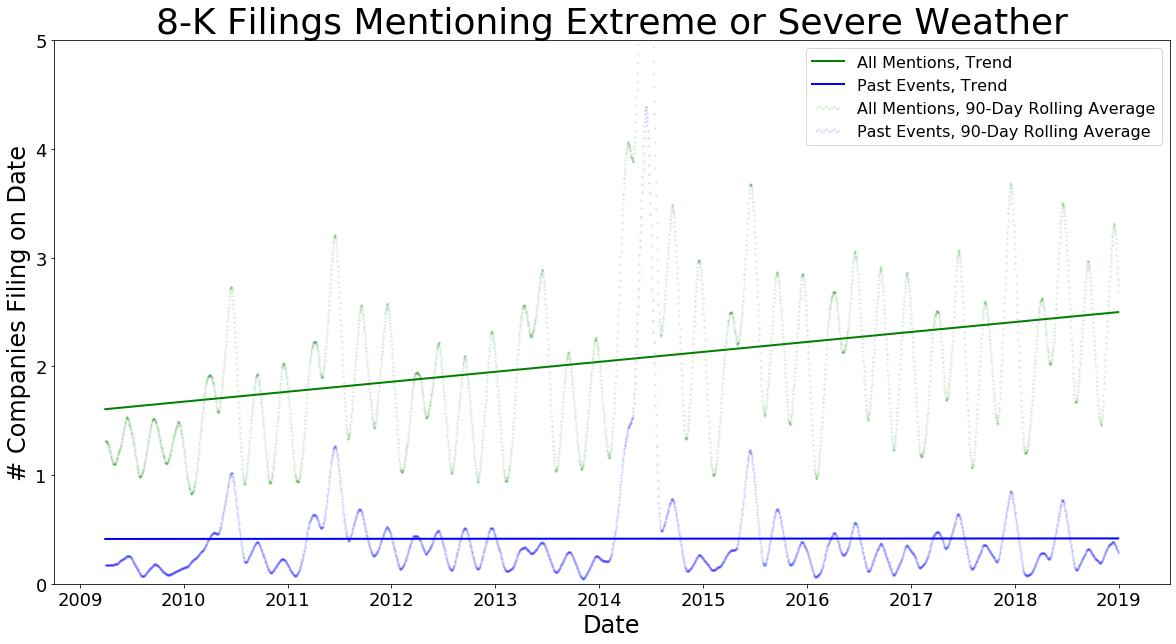

In [113]:
import matplotlib.dates as dates


titleSize = 36
labelSize = 24
tickSize  = 18



allCounts1        = smoothedAllCounts1[~smoothedAllCountsRolling.isna()]
allCountsRolling  = smoothedAllCountsRolling[~smoothedAllCountsRolling.isna()]

pastCounts1        = smoothedPastCounts1[~smoothedPastCountsRolling.isna()]
pastCountsRolling  = smoothedPastCountsRolling[~smoothedPastCountsRolling.isna()]

datesOfInterest    = allDays.date_time[~smoothedAllCountsRolling.isna()]
x_num     = dates.date2num(datesOfInterest)





########################################################################################

# misc formatting 
fig = plt.gcf()
fig.set_size_inches(20, 10)




##########################
# future - points and line

# plt.scatter(datesOfInterest, allCounts1, color='green', s=10, label="Daily Count", alpha=0.15)
plt.scatter(datesOfInterest, allCountsRolling, color='green', s=2.5, 
            label="All Mentions, 90-Day Rolling Average",alpha = 0.1)

# with trend
trendAll = np.polyfit(x_num, allCounts1, 1)
fitAll   = np.poly1d(trendAll)
plt.plot(x_num, fitAll(x_num), color = "green", label = "All Mentions, Trend", linewidth = 2)




##########################
# past - points and line
# plt.scatter(datesOfInterest, pastCounts1,       color='blue', s=5, label="Past Events",alpha = 0.25) #, alpha=0.5)
plt.scatter(datesOfInterest, pastCountsRolling, color='blue', s=2.5,
            label="Past Events, 90-Day Rolling Average",alpha = 0.1) #, alpha=0.5)
trendPast = np.polyfit(x_num, pastCounts1, 1)
fitPast   = np.poly1d(trendPast)
plt.plot(x_num, fitPast(x_num), color = "blue",  label = "Past Events, Trend", linewidth = 2)


plt.xlabel("Date",fontsize=labelSize)
plt.xticks(fontsize = tickSize)

plt.ylabel("# Companies Filing on Date",fontsize=labelSize)
plt.yticks(fontsize = tickSize)



######################################################################
# put everything together
plt.title("8-K Filings Mentioning Extreme or Severe Weather",fontsize=titleSize)


plt.ylim(top=5,bottom= 0)

plt.legend(fontsize=16,scatterpoints=10,loc='upper right')

plt.show()


The below allows us to go a little bit deeper into what is actually in the sentences.

In [ ]:
tempFiles['rain'] = checkMentions('rain',tempFiles)
tempFiles['extremeHeat'] = checkMentions('extreme heat',tempFiles)
tempFiles['heatWave'] = checkMentions('heat wave',tempFiles)
tempFiles['flood'] = checkMentions('flood',tempFiles)
tempFiles['extremeWeather'] = checkMentions('extreme weather',tempFiles)
tempFiles['severeWeather'] = checkMentions('severe weather',tempFiles)

print(tempFiles.shape)
tempFiles['weatherKey'] = tempFiles.rain | tempFiles.extremeHeat | tempFiles.heatWave | tempFiles.flood | tempFiles.extremeWeather | tempFiles.severeWeather
hasTerm = tempFiles[tempFiles['weatherKey']]
print(hasTerm.shape)

## Check Sentences
Now, go from the full text of the filings to specific sentences within it, to look at how the terms are being used.

In [ ]:
hasTerm = explodeSents(hasTerm)
print(tempFiles.shape,hasTerm.shape)

Now filter the sentences down.

In [ ]:
np.max([rainSent,heatSent],axis = 0)

In [ ]:
rainSent     = checkMentions('rain',hasTerm)
heatSent     = checkMentions('extreme heat',hasTerm)
heatwaveSent = checkMentions('heat wave',hasTerm)
floodSent    = checkMentions('flood',hasTerm)
extremeSent  = checkMentions('extreme weather',hasTerm)
severeSent   = checkMentions('severe weather',hasTerm)


weatherSent = np.max([rainSent,heatSent,floodSent,heatwaveSent,extremeSent,severeSent], axis = 0)


sentHasTerm = hasTerm[weatherSent]


sentHasTerm = sentHasTerm[['fdate', 'form', 'nitem','year','text']].drop_duplicates().reset_index()


print(sentHasTerm.shape)


sentHasTerm.head()

Tokenize the sentence and try to get at the tense of it.

In [ ]:
with multiprocessing.Pool() as pool:
    vals = pool.map(findTense,sentHasTerm.text)

    
sentHasTerm['vals'] = vals
sentHasTerm[['tense','tenseCounts','percPast']] = pd.DataFrame(sentHasTerm['vals'].tolist(), index= sentHasTerm.index)

past = sentHasTerm[(sentHasTerm.tense == 'past') & (sentHasTerm.percPast > 0.67)].reset_index()

In [ ]:
sentHasTerm.tense.value_counts()

In [ ]:
for row in range(0,past.shape[0]):
    print(past.nitem[row],past.tenseCounts[row], ':  ', past.text[row],"*********************************************************************************************************************************************************************************************")
    
    
    
    

In [ ]:
hasTerm[0:100].to_csv('sampleSents.csv')

##  Do some initial scraping

In [ ]:
os.getcwd()

### Read in the file structure

In [ ]:
os.getcwd()

In [ ]:
with open("../fileStructure.txt") as file:
    fileList = list(file)

In [ ]:
files = [sub.replace('\n', '') for sub in fileList][590:]

In [ ]:
from itertools import groupby
i = (list(g) for _, g in groupby(files, key=''.__ne__))
zippedFiles = [a + b for a, b in zip(i, i)]

In [ ]:
len(zippedFiles)

In [ ]:
fileList = []
start = time.time()

for i in range(0, len(zippedFiles)):
    base      = zippedFiles[i][0][:-1]
    fileNames = zippedFiles[i][1:-1]

    fullStructure = [base + '/' + s for s in fileNames]
    
    fileList.append(fullStructure)

time.time() - start

In [ ]:
allFiles = [item for sublist in fileList for item in sublist]
len(allFiles)

In [ ]:
allFilesDF.fileDirectory[0:5].str.split('/').str.get(6:8).str.split('.').str.get(0)

In [ ]:
allFilesDF                     = pd.DataFrame(allFiles)
allFilesDF.columns             = ['fileDirectory']
allFilesDF['accession_number'] = allFilesDF.fileDirectory.str.split('/').str.get(8).str.split('.').str.get(0)

In [ ]:
with open('allFiles_wrdsSEC.pkl', 'wb') as f:
   pkl.dump(allFilesDF, f)


In [ ]:
allFilesDF.head()

# Make filings list

## Track filings
See which filings actually mentioned the words they purport to

In [ ]:
relevantItems = pd.read_csv("../data/filings/wrds/relevantItems.csv")

In [ ]:
relevantItems['accession_number'] = relevantItems['fname'].str.split('/').str.get(3).str.split('.').str.get(0)

In [ ]:
relevantItems.tail()

In [ ]:
allFilesDF_filtered = allFilesDF[allFilesDF.accession_number.isin(relevantItems.accession_number)]

In [ ]:
getFileNames = relevantItems[['cik','fdate','form','nitem', \
               'item','accession_number']].merge(allFilesDF_filtered,how = 'left')

getFileNames.head()

In [ ]:
getFileNames.shape

In [ ]:
fileList = getFileNames.fileDirectory
fileList


textfile = open('../data/filings/wrds/fileList_relevantItems.txt', "w")
    
for element in list(fileList):
    textfile.write(element + "\n")

    
textfile.close()

# Make files
We'll make two distinct files here. 
1.  One is going to have all of the relevant items that contain one of the main climate words.
2. One is going to have all types of the relevant items.


The second one will allow us to use different text search capabilities within Python. I'm not 100\% sure how WRDS manages the search feature but it doesn't seem entirely great.


## Extreme Weather


In [ ]:
accessionNumbers = list(relevantItems.accession_number.unique())

In [ ]:
rain           = pd.read_csv("../data/filings/wrds/rainMentions.csv")
rain['weatherType'] = 'rain'
heat           = pd.read_csv("../data/filings/wrds/heatMentions.csv")
heat['weatherType'] = 'heat'
storm          = pd.read_csv("../data/filings/wrds/stormMentions.csv")
storm['weatherType'] = 'storm'
flood          = pd.read_csv("../data/filings/wrds/floodMentions.csv")
flood['weatherType'] = 'flood'
snow           = pd.read_csv("../data/filings/wrds/snowMentions.csv")
snow['weatherType'] = 'snow'
sevWeath       = pd.read_csv("../data/filings/wrds/severeWeather.csv")
sevWeath['weatherType'] = 'sevWeath'
extWeath       = pd.read_csv("../data/filings/wrds/extremeWeather.csv")
extWeath['weatherType'] = 'extWeath'

In [ ]:
def checkRain(strs):
    matchQ = re.search(r'\brain\b',strs,re.IGNORECASE)
    return(matchQ is not None)
def checkHeat(strs):
    matchQ = re.search(r'\bheat\b',strs,re.IGNORECASE)
    return(matchQ is not None)
def checkStorm(strs):
    matchQ = re.search(r'\bstorm\b',strs,re.IGNORECASE)
    return(matchQ is not None)
def checkFlood(strs):
    matchQ = re.search(r'\bflood\b',strs,re.IGNORECASE)
    return(matchQ is not None)
def checkSnow(strs):
    matchQ = re.search(r'\bsnow\b',strs,re.IGNORECASE)
    return(matchQ is not None)
def checkSevWeath(strs):
    matchQ = re.search(r'\bsevere weather\b',strs,re.IGNORECASE)
    return(matchQ is not None)
def checkExtWeath(strs):
    matchQ = re.search(r'\bextreme weather\b',strs,re.IGNORECASE)
    return(matchQ is not None)

In [ ]:
print(rain.shape)
rain = rain[rain.text_match.apply(checkRain)]
print(rain.shape,'***************')

print(heat.shape)
heat = heat[heat.text_match.apply(checkHeat)]
print(heat.shape,'***************')

print(storm.shape)
storm = storm[storm.text_match.apply(checkStorm)]
print(storm.shape,'***************')

print(flood.shape)
flood = flood[flood.text_match.apply(checkFlood)]
print(flood.shape,'***************')

print(snow.shape)
snow = snow[snow.text_match.apply(checkSnow)]
print(snow.shape,'***************')

print(sevWeath.shape)
sevWeath = sevWeath[sevWeath.text_match.apply(checkSevWeath)]
print(sevWeath.shape,'***************')

print(extWeath.shape)
extWeath = extWeath[extWeath.text_match.apply(checkExtWeath)]
print(extWeath.shape,'***************')



In [ ]:
weatherMentions = rain.append(heat).append(storm).append(flood).append(snow).append(sevWeath).append(extWeath)
# weatherMentions = sevWeath.append(extWeath)

weatherMentions = weatherMentions[['filed_as_of_date', 'filer_central_index_key', 
                                   'accession_number','weatherType','id',
                                  'text_match']].drop_duplicates()
sum(weatherMentions.accession_number.isin(accessionNumbers))

weatherMentions = weatherMentions.merge(relevantItems[['accession_number','nitem']])

weatherMentions.head()

In [ ]:
checkReports = weatherMentions.groupby(['weatherType','nitem']).size().reset_index()
checkReports.columns = ['weatherType', 'nitem', 'count']
checkReports.sort_values(by=['nitem'],ascending = False)

In [ ]:
for test in weatherMentions[weatherMentions.nitem.isin([2.06])].text_match:
    print(test)

In [ ]:
weatherMentions.to_csv("../data/filings/wrds/filingsByType.csv")

In [ ]:
weatherMentions.id.unique()

In [ ]:
fileList = '../../../wrds/sec/wrds_clean_filings/' + weatherMentions.id.unique()
fileList


textfile = open('../data/filings/wrds/fileList.txt', "w")
    
for element in list(fileList):
    textfile.write(element + "\n")

    
textfile.close()

## All Relevant Filings

In [ ]:
relevantItems.head()

In [ ]:
fileList = '../../../wrds/sec/wrds_clean_filings/*' + relevantItems.accession_number.unique() + '.txt'
fileList


textfile = open('../data/filings/wrds/fileList_allItems.txt', "w")
    
for element in list(fileList):
    textfile.write(element + "\n")

    
textfile.close()

In [ ]:
fileList

In [ ]:
for filename in os.listdir('../../../wrds/sec/wrds_clean_filings/'):
    print(filename)